# <font color='blue'> PPHA 30546 Machine Learning | PS3</font> 

Kathy Zhang, Yimeng Wu

In [19]:
# Import the libraries
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.formula.api import ols
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LinearRegression, Lasso
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.metrics import mean_absolute_error, r2_score, mean_squared_error
from sklearn.metrics import accuracy_score, confusion_matrix, roc_curve
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import cross_val_score, cross_validate
from sympy import symbols, Eq, solve, exp

from IPython.display import Image
from IPython.core.display import HTML 

from itertools import combinations

import warnings
warnings.filterwarnings('ignore')

###  CH5 Q6
#### 6. We continue to consider the use of a logistic regression model to predict the probability of default using income and balance on the Default data set. In particular, we will now compute estimates for the standard errors of the income and balance logistic regression coefficients in two different ways: (1) using the bootstrap, and (2) using the standard formula for computing the standard errors in the sm.GLM() function. Do not forget to set a random seed before beginning your analysis. 

• In parts (a) and (d), the problem references the sm.glm() function. You can use the sm.Logit() function instead if you’d prefer. The sm.glm() function is more general way to estimate different linear models (hence the GLM name), but it will estimate a logistic regression with the appropriate arguments.

• Part (a) also references the summarize() function. This is a typo. The authors mean the .summary() method as a way to view the results of a sm.glm() fit.

• In part (c), please draw 1,000 bootstrap samples when bootstrapping your standard errors.

#### (a) Using the summarize() and sm.GLM() functions, determine the estimated standard errors for the coefficients associated with income and balance in a multiple logistic regression model that uses both predictors.

<font color='blue'> We first assigned dummies for default and student. The estimated SE for balance is 0, for income is 4.99e-06, for constant is 0.435. Coefficient estimates for the above are 0.0056, 2.081e-05, and -11.5405 respectively.

In [20]:
default = pd.read_csv('Data-Default.csv')
print(default.shape, '\n')
default.head()

(10000, 4) 



,default,student,balance,income
0,No,No,729.526495,44361.625074
1,No,Yes,817.180407,12106.134700
2,No,No,1073.549164,31767.138947
3,No,No,529.250605,35704.493935
4,No,No,785.655883,38463.495879


In [21]:
# Make default and student dummy variables
encoding_dict = {'Yes': 1,'No': 0}
for col in ['default', 'student']:
    default[col] = default[col].map(encoding_dict)
default.head()

,default,student,balance,income
0,0,0,729.526495,44361.625074
1,0,1,817.180407,12106.134700
2,0,0,1073.549164,31767.138947
3,0,0,529.250605,35704.493935
4,0,0,785.655883,38463.495879


In [22]:
np.random.seed(1) # set a random seed

# Build the logistic regression model
X = default[['balance', 'income']]
X = sm.add_constant(X)
y = default['default']

results = sm.GLM(y, X, family=sm.families.Binomial()).fit() # binary outcome
print(results.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:                default   No. Observations:                10000
Model:                            GLM   Df Residuals:                     9997
Model Family:                Binomial   Df Model:                            2
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -789.48
Date:                Tue, 13 Feb 2024   Deviance:                       1579.0
Time:                        15:07:11   Pearson chi2:                 6.95e+03
No. Iterations:                     9   Pseudo R-squ. (CS):             0.1256
Covariance Type:            nonrobust                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const        -11.5405      0.435    -26.544      0.0

#### (b) Write a function, boot_fn(), that takes as input the Default data set as well as an index of the observations, and that outputs the coefficient estimates for income and balance in the multiple logistic regression model.

In [23]:
def get_indices(data, n):
    '''
    Generates a random subsample (i.e., its indices)
    with replacement consisting of n observations each.

    Args
    ----
        - data (pd.Dataframe): data to sample from
        - n (int): number of observations in the sample
    
    Returns
    -------
        - indices (np.ndarray): array of indices forming
            the samples
    '''
    assert type(data) == pd.DataFrame
    assert type(n) == int, 'n must be an integer'

    indices = np.random.choice(
        data.index,         # Indices as the input
        int(n),             # Number of indices per sample
        replace=True        # Draw samples with replacement
    )
    return indices

get_indices(default, 5)

array([ 235, 5192,  905, 7813, 2895], dtype=int64)

In [24]:
def boot_fn(data, index, constant=True, features=['balance','income'],
            target='default'):
    '''
    Runs a logistic regression (with a constant) on only the specified
    indices within the data (i.e., on a single subsample).

    Args
    ----
        - data (pd.Dataframe): data to sample from
        - indices (np.ndarray): array of indices forming the samples
        - features (lst of str): the name of the features
        - target (str): the name of the target

    Returns
    -------
        - coefficients (lst of float): the coefficients
    '''
    X = data[features].loc[index]
    if constant:
        X = sm.add_constant(X)
    y = data[target].loc[index]
    
    lr = sm.GLM(y, X, family=sm.families.Binomial()).fit(disp=0)
    coefficients = [lr.params[0], lr.params[1], lr.params[2]]

    return coefficients

intercept, coef_balance, coef_income = boot_fn(default,
                                               get_indices(default, 10000))
print(f'Coefficients of a single subsample:\n\tIntercept:\t{round(intercept,5)}\n\tBalance:\t{round(coef_balance, 5)}\n\tIncome:\t\t{round(coef_income, 8)}')

Coefficients of a single subsample:
	Intercept:	-11.65874
	Balance:	0.00575
	Income:		1.919e-05


#### (c) Following the bootstrap example in the lab, use your boot_fn() function to estimate the standard errors of the logistic regression coefficients for income and balance.

<font color='blue'> Estimated coefficients on balance and income are 0.0057 and 2.102e-05, with standard errors being 0.00023 and 5.035e-06 respectively.

In [25]:
def boot(data, func, B):
    '''
    Executing a bootstrap over B subsamples
    to estimate the (mean of) coefficients
    and their associated standard errors.

    Inputs:
        - data (pd.Dataframe): data to sample from
        - func (fn): function executing the regression
        - B (int): number of subsamples
    
    Ouput:
        - restults (dict of dicts): bootstrapped coefficients
            and the associated standard errors
    '''
    # Step 4
    coef_intercept = []
    coef_balance = []
    coef_income = []

    coefs = ['intercept', 'balance', 'income']
    output = {coef: [] for coef in coefs}
    for i in range(B):
        reg_out = func(data, get_indices(data, len(data)))
        for i, coef in enumerate(coefs):
            output[coef].append(reg_out[i])

    # Step 5
    results = {}
    for coef in coefs:
        results[coef] = {
            'estimate': np.mean(output[coef]),
            'std_err': np.std(output[coef])
        }
    
    return results

In [26]:
results = boot(default, boot_fn, 1000)
for i, x in results.items():
    print(f"{i.capitalize()}:\n\tEstimate: {x['estimate']}\n\tStandard Error: {x['std_err']}")

Intercept:
	Estimate: -11.573858754859323
	Standard Error: 0.448417021813344
Balance:
	Estimate: 0.005662047099121872
	Standard Error: 0.00023244529100075235
Income:
	Estimate: 2.102052289223684e-05
	Standard Error: 5.035000021103877e-06


#### (d) Comment on the estimated standard errors obtained using the sm.GLM() function and using the bootstrap.

<font color='blue'> The estimated SEs obtained using boostrap (0.00023, 5.035e-6) are a little bit higher that those using sm.GLM() function (0, 4.99e-0.6) but very close to each other (they equalize at 0.001 level), indicating that bootstraping provides robust and reliable estimates SEs for coefficients from a logistic regression fit. By using bootstrap, we reduce the risk of overfitting and improve the stability of our machine learning algorithms.

<font color='blue'>The standard forms using sm.GLM() depend on the unknown parameter, such as the noise variance $ \sigma^2 $. Secondly, standard formulas assume that xi are fixed, and all the variability comes from the variation in the error terms. The bootstrap approach does not rely on any of these assumptions. The bootstrap method, being a non-parametric approach that makes fewer assumptions, may be providing a more accurate reflection of the uncertainty associated with each coefficient estimate.

###  CH5 Q8

#### 8. We will now perform cross-validation on a simulated data set.

• In part (a), note that the code you’re given sets a random seed equal to 1.

• In part (c), please keep the same random seed as in part (a).

• In part (d), please set a random seed equal to 2.

#### (a) Generate a simulated data set as follows:
`rng = np.random.default_rng(1)`

`x = rng.normal(size=100)`

`y = x - 2 * x**2 + rng.normal(size=100)`

#### In this data set, what is n and what is p? Write out the model used to generate the data in equation form.

<font color='blue'> n is number of observations = 100, p is the number of predictors = 2. The true model is:

<font color='blue'> $ Y = X - 2X^2 + ϵ$

In [27]:
np.random.seed(1) # set a random seed

rng = np.random.default_rng(1)
x = rng.normal(size=100)
y = x - 2 * x**2 + rng.normal(size=100)

#### (b) Create a scatterplot of X against Y . Comment on what you find.

<font color='blue'> The plot shows a quadratic, negative convex relationship between X and Y, where Y first increases and then decreases when X reaches ~0 as X increases. X ranges from -2 to 2 and Y ranges from -15 to 2.

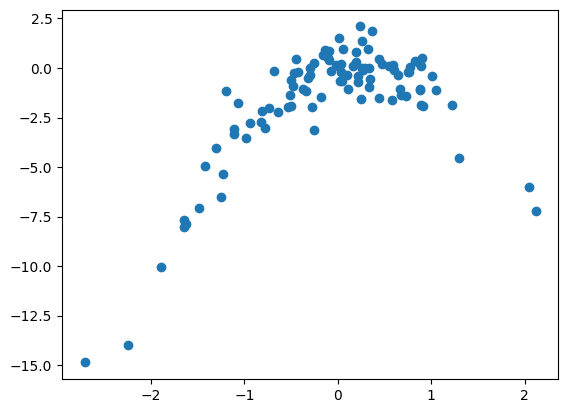

In [28]:
plt.scatter(x, y)

#### (c) Set a random seed, and then compute the LOOCV errors that result from fitting the following four models using least squares:

i. $ Y = B0 + B1X + ϵ $

ii. $ Y = B0 + B1X + B2X^2 + ϵ $ 

iii. $ Y = B0 + B1X + B2X^2 + B3X^3 + ϵ $

iv. $ Y = B0 + B1X + B2X^2 + B3X^3 + B4X^4 + ϵ $.

#### Note you may find it helpful to use the data.frame() function to create a single data set containing both X and Y .

<font color='blue'> The LOOCV errors are calculated below.

<font color='blue'> The results are:

- <font color='blue'>Model 1: MSE = 6.633029839181983
- <font color='blue'>Model 2: MSE = 1.1229368563419677
- <font color='blue'>Model 3: MSE = 1.3017965489358883
- <font color='blue'>Model 4: MSE = 1.3323942694179352 

In [29]:
data = {
    'x': x,
    'x_2': np.power(x, 2),
    'x_3': np.power(x, 3),
    'x_4': np.power(x, 4),
    'y': y
}

df = pd.DataFrame(data)

In [30]:
df.head()

,x,x_2,x_3,x_4,y
0,0.345584,0.119428,0.041273,0.014263,-0.544554
1,0.821618,0.675056,0.554639,0.455701,0.333950
2,0.330437,0.109189,0.036080,0.011922,-0.013532
3,-1.303157,1.698219,-2.213046,2.883947,-4.030442
4,0.905356,0.819669,0.742092,0.671858,0.484861


In [31]:
np.random.seed(1) # set a random seed

models = {
    'Model 1': ['x'],
    'Model 2': ['x', 'x_2'],
    'Model 3': ['x', 'x_2', 'x_3'],
    'Model 4': ['x', 'x_2', 'x_3', 'x_4']
}

def calculate_mse_for_models(df, models):
    mse_results = {}

    for model_name, features in models.items():
        squared_errors = []
        
        for i in df.index:
            # Split the data into training and testing sets
            train = df.iloc[df.index != i]
            test = df.iloc[df.index == i]

            # Fit the model and gather the squared error
            ols = LinearRegression().fit(train[features], train['y'])
            test_predicted = ols.predict(test[features])
            test_actual = test['y']
            squared_error = np.power(test_predicted - test_actual, 2)
            
            # Store the squared error
            squared_errors.append(squared_error.values[0])
        
        # Calculate the MSE using LOOCV for the model
        mse_results[model_name] = np.mean(squared_errors)

    # Print the MSE results for each model
    for model_name, mse in mse_results.items():
        print(f'{model_name}: MSE = {mse}')
        

calculate_mse_for_models(df, models)

Model 1: MSE = 6.633029839181983
Model 2: MSE = 1.1229368563419677
Model 3: MSE = 1.3017965489358883
Model 4: MSE = 1.3323942694179352


#### (d) Repeat (c) using another random seed, and report your results. Are your results the same as what you got in (c)? Why?

<font color='blue'> The results are exactly the same using random seed = 1 and 2. This consistency arises because only a single observation is excluded from the training set in each iteration of the LOOCV process. Consequently, the selection of observations for the test set does not introduce any randomness into the procedure. Therefore, the LOOCV results will be invariant to the choice of random seed.

In [32]:
np.random.seed(2) # set a different random seed

calculate_mse_for_models(df, models)

Model 1: MSE = 6.633029839181983
Model 2: MSE = 1.1229368563419677
Model 3: MSE = 1.3017965489358883
Model 4: MSE = 1.3323942694179352


#### (e) Which of the models in (c) had the smallest LOOCV error? Is this what you expected? Explain your answer.

<font color='blue'> Model 2 had the smallest LOOCV error of 1.12, which is indeed what we expected since we created y based on exactly Model 2, the quadratic form. Model 1 has the highest MSE of 6.63 since it does not account for quadratic, non-linear relationships, then Model 2 has the least MSE, while MSE increases going from Model 2 to 3 to 1.30, 3 to 4 to 1.33 since x^3 and x^4 are irrelevant.


#### (f) Comment on the statistical significance of the coefficient estimates that results from fitting each of the models in (c) using least squares. Do these results agree with the conclusions drawn based on the cross-validation results?

<font color='blue'> 
t-stats and p-values for each ceofficient estimates in below models:

| t-stats/p-values   | Model 1   | Model 2    | Model 3   | Model 4   |
|-------------|-------------|-------------|-------------|-------------|
| $ x $ | 6.752/0 | 7.647/0  | 5.945/0 | 4.423/0|
| $ x^2 $ |  | -22.072/0 | -20.673/0 | -11.336/0 | 
| $ x^3 $ |  |  | -1.07/0.287 | 0.466/0.642 |
| $ x^4 $ |  |  |  | 2.309/0.023 |

Significance of $ x^2 > x > x^4 > x^3 $

Model 2 still has the highest statistical significance with both p-values for its coefficient estimates with best second degree variable followed by first degree variable based on t-stats. 

It is notable that all coefficient estimates on $ x $ and $ x^2 $ for all models are statistically significant with p values < 0.05 at 95% confidence level, and Model 3 and 4 do not have statistically significant $ x^3 $ at 95% confidence level, Model 4 does not have statistically significant $ x^4 $ at 98% confidence level. For each of the models, the absolute t-stats on ceofficient estimate $ x^2 $ are also the highest--22, 21, 11, and it decreases as we add more irrelevant variables. 
Hence, these results agree with the conclusions drawn based on the cross-validation results that $ x $ and $ x^2 $ are variables with relevance and significance for the models. 

In [33]:
# Print summary table for each regression
for model_name, features in models.items():
        model = sm.OLS(df['y'], sm.add_constant(df[features]))
        results = model.fit()
        print(model_name)
        print(results.summary())

Model 1
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.318
Model:                            OLS   Adj. R-squared:                  0.311
Method:                 Least Squares   F-statistic:                     45.60
Date:                Tue, 13 Feb 2024   Prob (F-statistic):           1.04e-09
Time:                        15:07:30   Log-Likelihood:                -230.83
No. Observations:                 100   AIC:                             465.7
Df Residuals:                      98   BIC:                             470.9
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -1.4650      0.247     -5.937 

###  CH6 Q11

#### 11. We will now try to predict per capita crime rate in the Boston dataset.

• In part (a), use forward stepwise & backwards stepwise selection (FSS & BSS) instead of the methods the book lists. Do so based on using a mathematical adjustment approach (AIC) and 5-Fold Cross-Validation (5FCV) to estimate the test error. Use the entire dataset for 5FCV, shuffle the data randomly for splitting, and set random_state=23). This means you will select a model four different ways: FSS-AIC, FSS-5FCV, BSS-AIC, BSS-5FCV.

• As part of your answer for part (b), be sure to explain why the the different methods you use may select different models.



#### (a) Try out some of the regression methods explored in this chapter, such as best subset selection, the lasso, ridge regression, and PCR. Present and discuss results for the approaches that you consider.


<font color='blue'> The above model selection methods generated the below four models with relevant statistics:

- <font color='blue'>FSS-AIC: ['constant', 'RAD', 'LSTAT', 'B', 'MDEV', 'ZN', 'DIS', 'NOX', 'PTRATIO'] (8 VARIABLES)

    <font color='blue'>AIC: 3332.396301742922

- <font color='blue'>FSS-5FCV: ['constant', 'RAD', 'LSTAT', 'MDEV', 'PTRATIO', 'ZN', 'DIS', 'NOX', 'INDUS', 'CHAS'] (9 VARIABLES)

    <font color='blue'>Error rate: 42.016041492205616

- <font color='blue'>BSS-AIC: ['ZN', 'NOX', 'DIS', 'RAD', 'PTRATIO', 'B', 'LSTAT', 'MDEV', 'constant'] (8 VARIABLES)

    <font color='blue'>AIC: 3332.3963017429214

- <font color='blue'>BSS-5FCV: ['constant', 'ZN', 'INDUS', 'CHAS', 'NOX', 'DIS', 'RAD', 'PTRATIO', 'LSTAT', 'MDEV'] (9 VARIABLES)

    <font color='blue'>Error rate: 42.01604149220564


<font color='blue'>It is notable that forward or backward stepwise selection does not make a difference--AICs and error rates generated using the two models are exactly the same respectively--3332.4=3332.4, 42.02=42.02. There is very minor differences in AIC and error rates even with the same variables, likely due to error calculations during the forward and backward selection process, but they are in fact the same models.

<font color='blue'>Here are some interpretations for AIC, 5FCV, Forward vs Backward Stepwise Selection, and variable selections:

- <font color='blue'>AIC (Akaike Information Criterion) is a measure of the relative quality of a statistical model for a given set of data. It balances the complexity of the model against how well the model fits the data (likelihood). Lower AIC values indicate a better model. Both FSS-AIC and BSS-AIC have identified models with similar complexity and fit, as indicated by the nearly identical AIC values. This suggests that both methods converge to a model with the same balance between complexity and fit.

- <font color='blue'>5-Fold Cross-Validation (5FCV): This method divides the dataset into 5 parts, trains the model on 4 parts, and tests it on the remaining part. This process is repeated 5 times, with each part used for testing exactly once. The average error rate across all 5 tests provides a robust estimate of the model's predictive performance on unseen data. Lower error rates indicate better predictive performance. The same error rates for FSS-5FCV and BSS-5FCV suggests that both forward and backward selections, when coupled with 5FCV, lead to the same models.

- <font color='blue'>The fact that both FSS-5FCV and BSS-5FCV, FSS-AIC and BSS-AIC select the same variables highlights a key point about stepwise selection methods: while the direction of the selection process might influence the order in which variables are added or removed during the model-building process, the final set of chosen variables can be the same if the selection criteria identifies a clear set of variables that contribute most significantly to predicting the target variable.

- <font color='blue'>Another finding is more variables, higher flexibility does not imply a lower error, and it is helpful to use these variable selection methods to reduce overfitting, balance between bias and variance. Moreover, certain variables are significant to determining crime rates as they appear in all models, such as `RAD`, `LSTAT`, `MEDEV`, `ZN`, `DIS`, `NOX`, `PTRATIO`. 

In [35]:
# Read in data
boston = pd.read_csv('Boston.csv')
print(boston.columns)
boston.head()

Index(['CRIM', 'ZN', 'INDUS', 'CHAS', 'NOX', 'RM', 'AGE', 'DIS', 'RAD', 'TAX',
       'PTRATIO', 'B', 'LSTAT', 'MDEV'],
      dtype='object')


,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,MDEV
0,0.00632,18.0,2.31,0.0,0.538,6.575,65.2,4.0900,1.0,296.0,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0.0,0.469,6.421,78.9,4.9671,2.0,242.0,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0.0,0.469,7.185,61.1,4.9671,2.0,242.0,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0.0,0.458,6.998,45.8,6.0622,3.0,222.0,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0.0,0.458,7.147,54.2,6.0622,3.0,222.0,18.7,396.90,5.33,36.2


### Forward stepwise with AIC (FSS-AIC)

In [36]:
# FSS-AIC
# Add constant to dataframe
boston['constant'] = 1 
vars_left_add = ['ZN', 'INDUS', 'CHAS', 'NOX', 'RM', 'AGE', 'DIS',
                 'RAD', 'TAX', 'PTRATIO', 'B', 'LSTAT', 'MDEV']


def forward_stepwise_selection_aic(data, vars, target):
    """Return the best model with the lowest AIC using forward stepwise selection.

    Args:
        data (dataframe): entire dataframe
        vars (list): list of variables
        target (string): name of the target variable

    Returns:
        list: best model list that contains selected variables, best AIC, and best model
    """
    remaining_vars = vars[:]
    current_vars = ['constant']
    best_aic = np.inf
    aic_list = []
    
    for iter in range(len(remaining_vars)):
        aic_candidates = []
        for var in remaining_vars:
            X_train = sm.add_constant(data[current_vars + [var]])
            y_train = data[target]
            model = sm.OLS(y_train, X_train).fit()
            aic_candidates.append((model.aic, var, model))
        
        aic_candidates.sort()
        best_new_aic, best_predictor, best_model = aic_candidates[0]
        
        if best_new_aic < best_aic:
            current_vars.append(best_predictor)
            remaining_vars.remove(best_predictor)
            best_aic = best_new_aic
            aic_list.append((current_vars[:], best_aic, best_model))
        else:
            break
            
    return sorted(aic_list, key=lambda x: x[1])[0]

# Run FSS-AIC
fss_aic = forward_stepwise_selection_aic(boston, vars_left_add, 'CRIM')

# Display the best model
fss_aic_best_model_vars, best_fss_aic_score, fss_aic_best_model = fss_aic
print("Best FSS-AIC Model Predictors:", fss_aic_best_model_vars)
print("Best FSS-AIC Model AIC:", best_fss_aic_score)
print("Best FSS-AIC Model Summary:\n", fss_aic_best_model.summary())


Best FSS-AIC Model Predictors: ['constant', 'RAD', 'LSTAT', 'B', 'MDEV', 'ZN', 'DIS', 'NOX', 'PTRATIO']
Best FSS-AIC Model AIC: 3332.396301742922
Best FSS-AIC Model Summary:
                             OLS Regression Results                            
Dep. Variable:                   CRIM   R-squared:                       0.445
Model:                            OLS   Adj. R-squared:                  0.436
Method:                 Least Squares   F-statistic:                     49.78
Date:                Tue, 13 Feb 2024   Prob (F-statistic):           7.23e-59
Time:                        15:07:30   Log-Likelihood:                -1657.2
No. Observations:                 506   AIC:                             3332.
Df Residuals:                     497   BIC:                             3370.
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                 coef    std err   

### Forward stepwise with 5FCV (FSS-5FCV)

In [37]:
# FSS-5FCV

def forward_stepwise_selection_5fcv(data, vars, target):
    """Return the best model with the lowest 5fcv using forward stepwise selection.

    Args:
        data (dataframe): entire dataframe
        vars (list): list of variables
        target (string): name of the target variable

    Returns:
        list: best model list that contains selected variables, best error rate, and best model
    """
    remaining_vars = vars[:]
    current_vars = ['constant']
    ols = LinearRegression()
    X = data[current_vars]

    cv = KFold(5, shuffle=True, random_state=23)  

    benchmark_error = np.mean(-1*cross_val_score(ols, X, data[target], cv=cv,
                                                 scoring='neg_mean_squared_error'))
    print(' Initial run with only one var (constant term/only bias weight):',
          current_vars)
    print('      Benchmark error:', benchmark_error)
    print('')

    # Keep adding the best variables (until no improvement can be made)
    for iter in range(len(remaining_vars)):
        print('\033[1m'+ 'Iteration:', iter, '\033[0m')
        error_list = []
        # Iterate over all the variables left to add
        for var in remaining_vars:
            # Modify X according to current iteration
            X = data[current_vars + [var]]
            # Perform 5-fold CV to get errors
            error = np.mean(-1*cross_val_score(ols, X, data[target], cv = cv,
                                               scoring = 'neg_mean_squared_error'))
            error_list.append(error)
            print(' Running model with:', current_vars + [var])
            print('      Error:', error)

        # Chose the smallest error
        min_error = min(error_list)
        chosen_col_index = error_list.index(min_error)

        # If our current smallest error is smaller than our previous error, than we add a variable
        if min_error < benchmark_error:
            print('          *** Variable selected:', remaining_vars[chosen_col_index])
            print('          *** Min error selected:', min_error)
            print('          *** Chose the variable that generated the min error + was lower than previous error')
            print('')
            # Add the variable that produced the smallest error to current_vars
            current_vars.append(remaining_vars[chosen_col_index])
            # Delete chosen variable from remaining_vars
            del remaining_vars[chosen_col_index] 
            # Update benchmark_error
            benchmark_error = min_error

        # Otherwise, we stop our model
        else:
            print('          \033[4m*** No variable was selected', '\033[0m')
            print('          *** Previous error rate (',
                  benchmark_error,') is lower than smallest error rate of this iteration (',
                  min_error ,')')
            print('          *** Break')
            break

    print('')
    print('Best FSS-5FCV Model Predictors:', current_vars)
    print('Error rate:', benchmark_error)
    return [current_vars, benchmark_error]

fss_5fcv = forward_stepwise_selection_5fcv(boston, vars_left_add, 'CRIM')
fss_5fcv_best_model_vars, fss_5fcv_best_model = fss_5fcv


 Initial run with only one var (constant term/only bias weight): ['constant']
      Benchmark error: 73.8391309169969

Iteration: 0 
 Running model with: ['constant', 'ZN']
      Error: 70.960997430059
 Running model with: ['constant', 'INDUS']
      Error: 61.78518850081366
 Running model with: ['constant', 'CHAS']
      Error: 73.6962319501766
 Running model with: ['constant', 'NOX']
      Error: 61.032928313349714
 Running model with: ['constant', 'RM']
      Error: 70.56209468980886
 Running model with: ['constant', 'AGE']
      Error: 64.96223484409609
 Running model with: ['constant', 'DIS']
      Error: 63.47276994624402
 Running model with: ['constant', 'RAD']
      Error: 45.87063742559609
 Running model with: ['constant', 'TAX']
      Error: 49.54812111463557
 Running model with: ['constant', 'PTRATIO']
      Error: 67.79253077321663
 Running model with: ['constant', 'B']
      Error: 65.8945017536434
 Running model with: ['constant', 'LSTAT']
      Error: 59.03812316496426
 

### Backward stepwise with AIC (BSS-AIC)

In [38]:
# BSS-AIC

# Variables to remove iteratively
vars_left_to_drop = ['ZN', 'INDUS', 'CHAS', 'NOX', 'RM', 'AGE', 'DIS',
                    'RAD', 'TAX', 'PTRATIO', 'B', 'LSTAT', 'MDEV']


def backward_stepwise_selection_aic(data, predictors, target):
    """Return the best model with the lowest AIC using backward stepwise selection.

    Args:
        data (dataframe): entire dataframe
        vars (list): list of variables
        target (string): name of the target variable

    Returns:
        list: best model list that contains selected variables, best AIC, and best model
    """
    current_vars = ['constant'] + predictors[:]
    best_aic = np.inf
    aic_list = []
    model_list = []

    while len(current_vars) > 0:
        aic_candidates = []

        for var in current_vars:
            temp_vars = current_vars[:]
            temp_vars.remove(var)
            X_train = sm.add_constant(data[temp_vars])
            y_train = data[target]
            model = sm.OLS(y_train, X_train).fit()
            aic_candidates.append((model.aic, var, model))

        aic_candidates.sort()
        best_new_aic, removed_var, best_model = aic_candidates[0]

        if best_new_aic < best_aic:
            best_aic = best_new_aic
            current_vars.remove(removed_var)
            aic_list.append(best_aic)
            model_list.append((current_vars[:], best_model))
        else:
            # If no improvement, stop the process
            break

    # Return the history of AICs and models
    return model_list[-1]


bss_aic = backward_stepwise_selection_aic(boston, vars_left_to_drop, 'CRIM')

# Displaying the best model
bss_aic_best_model_vars, bss_aic_best_model = bss_aic
print("Best BSS-AIC Model Predictors::", bss_aic_best_model_vars)
print("Best BSS-AIC Model AIC:", bss_aic_best_model.aic)
print("Best BSS-AIC Model Summary:\n", bss_aic_best_model.summary())


Best BSS-AIC Model Predictors:: ['constant', 'ZN', 'NOX', 'DIS', 'RAD', 'PTRATIO', 'B', 'LSTAT', 'MDEV']
Best BSS-AIC Model AIC: 3332.3963017429214
Best BSS-AIC Model Summary:
                             OLS Regression Results                            
Dep. Variable:                   CRIM   R-squared:                       0.445
Model:                            OLS   Adj. R-squared:                  0.436
Method:                 Least Squares   F-statistic:                     49.78
Date:                Tue, 13 Feb 2024   Prob (F-statistic):           7.23e-59
Time:                        15:07:31   Log-Likelihood:                -1657.2
No. Observations:                 506   AIC:                             3332.
Df Residuals:                     497   BIC:                             3370.
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                 coef    std err 

### Backward stepwise with 5FCV (BSS-5FCV)

In [39]:
# BSS-5FCV

def backward_stepwise_selection_5fcv(data, vars, target):
    """Return the best model with the lowest 5fcv using backward stepwise selection.

    Args:
        data (dataframe): entire dataframe
        vars (list): list of variables
        target (string): name of the target variable

    Returns:
        list: best model list that contains selected variables, best error rate, and best model
    """
    remaining_vars = vars[:]
    current_vars = ['constant'] + remaining_vars
    ols = LinearRegression()
    X = data[current_vars]

    cv = KFold(5, shuffle=True, random_state=23)  

    benchmark_error = np.mean(-1*cross_val_score(ols, X, data[target], cv=cv,
                                                scoring = 'neg_mean_squared_error'))
    print(' Initial run with all vars:', current_vars)
    print('      Benchmark error:', benchmark_error)
    print('')

    # Keep removing the worst variables (until no improvement can be made)
    for iter in range(len(remaining_vars)):
        print('\033[1m'+ 'Iteration:', iter, '\033[0m')
        error_list = []
        # Iterate over all the variables left to remove
        for var in remaining_vars:
            # Modify X according to current iteration
            vars_to_be_used = ['constant'] + [i for i in remaining_vars if i != var]
            X = data[['constant'] + [i for i in remaining_vars if i != var]]
            # Perform 5-fold CV to get errors
            error = np.mean(-1*cross_val_score(ols, X, data[target], cv = cv,
                                               scoring = 'neg_mean_squared_error'))
            error_list.append(error)
            print(' Running model with:', vars_to_be_used)
            print('      Error:', error)

        # Chose the largest error
        min_error = min(error_list)
        chosen_col_index = error_list.index(min_error)

        # If our current smallest error is smaller than our previous error, then we drop the variable associated with it
        if min_error < benchmark_error:
            print('          *** Will drop:', remaining_vars[chosen_col_index])
            print('          *** Min error selected:', min_error)
            print('          *** Chose the variable that generated the min error + was lower than previous error')
            print('')
            # Delete chosen variable from current_vars and remaining_vars
            del current_vars[chosen_col_index + 1]
            del remaining_vars[chosen_col_index]
            # Update benchmark_error
            benchmark_error = min_error
        
        # If not, we keep our model
        else:
            print('          \033[4m*** No variable was selected', '\033[0m')
            print('          *** Previous error rate (',
                  benchmark_error,') is lower than smallest error rate of this iteration (',
                  min_error ,')')
            print('          *** Break')
            break

    print('')
    print('Best BSS-5FCV Model Predictors:', current_vars)
    print('Error rate:', benchmark_error)
    return [current_vars, benchmark_error]


bss_5fcv = backward_stepwise_selection_5fcv(boston, vars_left_to_drop, 'CRIM')
bss_5fcv_best_model_vars, bss_5fcv_best_model = bss_5fcv

 Initial run with all vars: ['constant', 'ZN', 'INDUS', 'CHAS', 'NOX', 'RM', 'AGE', 'DIS', 'RAD', 'TAX', 'PTRATIO', 'B', 'LSTAT', 'MDEV']
      Benchmark error: 43.90194865511775

Iteration: 0 
 Running model with: ['constant', 'INDUS', 'CHAS', 'NOX', 'RM', 'AGE', 'DIS', 'RAD', 'TAX', 'PTRATIO', 'B', 'LSTAT', 'MDEV']
      Error: 44.42441330332993
 Running model with: ['constant', 'ZN', 'CHAS', 'NOX', 'RM', 'AGE', 'DIS', 'RAD', 'TAX', 'PTRATIO', 'B', 'LSTAT', 'MDEV']
      Error: 43.92995670932905
 Running model with: ['constant', 'ZN', 'INDUS', 'NOX', 'RM', 'AGE', 'DIS', 'RAD', 'TAX', 'PTRATIO', 'B', 'LSTAT', 'MDEV']
      Error: 43.90331400716521
 Running model with: ['constant', 'ZN', 'INDUS', 'CHAS', 'RM', 'AGE', 'DIS', 'RAD', 'TAX', 'PTRATIO', 'B', 'LSTAT', 'MDEV']
      Error: 44.24334151226175
 Running model with: ['constant', 'ZN', 'INDUS', 'CHAS', 'NOX', 'AGE', 'DIS', 'RAD', 'TAX', 'PTRATIO', 'B', 'LSTAT', 'MDEV']
      Error: 43.836679592660445
 Running model with: ['constant

#### (b) Propose a model (or set of models) that seem to perform well on this data set, and justify your answer. Make sure that you are evaluating model performance using validation set error, crossvalidation, or some other reasonable alternative, as opposed to using training error.

<font color='blue'> 

By using Leave One Out Cross-Validation on the four models from the above to assess model performance, the model selected through 5FCV minimization shows a lower MSE (42.439) compared to models using AIC (42.995), indicating that it has achieved a good balance between bias and variance.  This model select the following 9 variables (if we drop constant): ['RAD', 'LSTAT', 'MDEV', 'PTRATIO', 'ZN', 'DIS', 'NOX', 'INDUS', 'CHAS']. It is not surprising that 5FCV gives the best result since it is using cross-validation similar to Leave One Out Cross-Validation approach while Akaike informa- tion criterion (AIC). 

As we discussed earlier, this outcome suggests a strong consensus between the forward and backward selection approaches under the 5FCV or AIC criterion regarding which variables are most important for predicting the per capita crime rate in the Boston dataset. The consistency in variable selection across both methods reinforces the reliability of these variables in modeling the crime rate, despite the inherent differences in the FSS and BSS methodologies.

Using LOOCV, MSEs for each model:

- FSS-AIC: 42.99482

- FSS-5FCV: 42.43918

- BSS-AIC: 42.99482

- BSS-5FCV: 42.43918


In [40]:
# FSS-AIC model, error rate using LOOCV
squared_errors = []

# Iterate over the entire dataset one observation at a time
print('Iternation Milestones:...')
for i in boston.index:
    # All except observation i is our training set
    train = boston.iloc[boston.index != i,:]
    # Only observation i is our test set
    test = boston.iloc[boston.index == i,:]

    # Fit the model and gather the squared error
    ols = LinearRegression().fit(train[fss_aic_best_model_vars], train['CRIM'])
    test_predicted = ols.predict(test[fss_aic_best_model_vars])
    test_actual = test[['CRIM']]
    squared_error = np.power(test_predicted - test_actual, 2)

    # Store the squared error
    squared_errors.append(squared_error.values[0][0])

    if i % 1000 == 0:
        print(i)

print(f'\n{squared_errors[:10]}\n')

# From the squared errors, get the Mean Squared Error (MSE)
print(f'MSE using best model from FSS-AIC: {round(np.mean(squared_errors), 5)}')

Iternation Milestones:...
0

[1.2845590250509065, 1.5209451136380667, 16.813111161336856, 21.72260543630353, 24.747257342005703, 12.609986268201185, 0.30472302763454906, 0.010151612077495816, 10.024647784307707, 0.6295305424967303]

MSE using best model from FSS-AIC: 42.99482


In [41]:
# FSS-5FCV model, error rate using LOOCV
squared_errors = []

# Iterate over the entire dataset one observation at a time
print('Iternation Milestones:...')
for i in boston.index:
    # All except observation i is our training set
    train = boston.iloc[boston.index != i,:]
    # Only observation i is our test set
    test = boston.iloc[boston.index == i,:]

    # Fit the model and gather the squared error
    ols = LinearRegression().fit(train[fss_5fcv_best_model_vars], train['CRIM'])
    test_predicted = ols.predict(test[fss_5fcv_best_model_vars])
    test_actual = test[['CRIM']]
    squared_error = np.power(test_predicted - test_actual, 2)

    # Store the squared error
    squared_errors.append(squared_error.values[0][0])

    if i % 1000 == 0:
        print(i)

print(f'\n{squared_errors[:10]}\n')

# From the squared errors, get the Mean Squared Error (MSE)
print(f'MSE using best model from FSS-5FCV: {round(np.mean(squared_errors), 5)}')

Iternation Milestones:...
0

[0.1999346270056265, 1.310230599235957, 18.515001163002044, 20.306044925952737, 23.18055553315749, 10.90091345587461, 0.6055271890566275, 0.1065283555189365, 13.048082605909899, 0.9504486755920881]

MSE using best model from FSS-5FCV: 42.43918


In [42]:
# BSS-AIC model, error rate using LOOCV
squared_errors = []

# Iterate over the entire dataset one observation at a time
print('Iternation Milestones:...')
for i in boston.index:
    # All except observation i is our training set
    train = boston.iloc[boston.index != i,:]
    # Only observation i is our test set
    test = boston.iloc[boston.index == i,:]

    # Fit the model and gather the squared error
    ols = LinearRegression().fit(train[bss_aic_best_model_vars], train['CRIM'])
    test_predicted = ols.predict(test[bss_aic_best_model_vars])
    test_actual = test[['CRIM']]
    squared_error = np.power(test_predicted - test_actual, 2)

    # Store the squared error
    squared_errors.append(squared_error.values[0][0])

    if i % 1000 == 0:
        print(i)

print(f'\n{squared_errors[:10]}\n')

# From the squared errors, get the Mean Squared Error (MSE)
print(f'MSE using best model from BSS-AIC: {round(np.mean(squared_errors), 5)}')

Iternation Milestones:...
0

[1.2845590250510837, 1.520945113638023, 16.813111161337, 21.72260543630317, 24.747257342005597, 12.609986268201563, 0.30472302763456866, 0.010151612077494385, 10.024647784308, 0.6295305424966458]

MSE using best model from BSS-AIC: 42.99482


In [43]:
# BSS-5FCV model, error rate using LOOCV
squared_errors = []

# Iterate over the entire dataset one observation at a time
print('Iternation Milestones:...')
for i in boston.index:
    # All except observation i is our training set
    train = boston.iloc[boston.index != i,:]
    # Only observation i is our test set
    test = boston.iloc[boston.index == i,:]

    # Fit the model and gather the squared error
    ols = LinearRegression().fit(train[bss_5fcv_best_model_vars], train['CRIM'])
    test_predicted = ols.predict(test[bss_5fcv_best_model_vars])
    test_actual = test[['CRIM']]
    squared_error = np.power(test_predicted - test_actual, 2)

    # Store the squared error
    squared_errors.append(squared_error.values[0][0])

    if i % 1000 == 0:
        print(i)

print(f'\n{squared_errors[:10]}\n')

# From the squared errors, get the Mean Squared Error (MSE)
print(f'MSE using best model from BSS-5FCV: {round(np.mean(squared_errors), 5)}')

Iternation Milestones:...
0

[0.19993462700563921, 1.310230599235884, 18.51500116300201, 20.306044925952673, 23.180555533157115, 10.900913455874587, 0.605527189056644, 0.10652835551894345, 13.048082605910027, 0.9504486755921054]

MSE using best model from BSS-5FCV: 42.43918


#### (c) Does your chosen model involve all of the features in the dataset? Why or why not?

<font color='blue'> No, our best model only used 9 features, because based on error calculation, it provides the best accuracy. This phenomenon, where fewer variables lead to lower MSE, aligns with the principle of parsimony in statistical modeling — the idea that among models with similar predictive capabilities, the simpler model is preferred. By focusing on a subset of significant predictors, the model avoids fitting to the noise in the data, leading to better generalization and lower MSE on new data. This also reflects a result of balancing between bias and variance--while bias decrease as number of predictors increase, variance may increase and incease resulting errors, which means more flexibility and more predictors are not necessarily better for reducing errors. See part (a) for more of my previous discussions on significant variables.